# HyperParameter Testing

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
import wrds
import sys
sys.path.append('..')
import imageio.v2 as imageio
import os

# Import Main Python Modules
from src.dataframe_construction import *
from src.a_estimation import *
from src.optimal_strategies import *
from src.backtest import *


### Backtesting

#### Setting up the data

In [2]:
daily = True
datapath='../data/'
backtest_start_year = 2014

if daily:
    d = 3000
    start_date_a_estimation='2013-01-01'
    end_date_a_estimation=str(backtest_start_year)+'-01-01'
    start_date_backtest=end_date_a_estimation
    end_date_backtest='2025-01-01'
    start_date='2013-01-01'
    filename='CRSP_2013_2018_daily_cleaned.h5'
    caps_table='dlyprevcap'
    returns_table='dlyret'
else:
    d = 2000
    start_date_a_estimation='1965-01-01'
    end_date_a_estimation=str(backtest_start_year)+'-01-01'
    start_date_backtest=end_date_a_estimation
    end_date_backtest='2025-01-01'
    filename='CRSP_monthly_cleaned.h5'
    caps_table='mthprevcap'
    returns_table='mthret'

df_a_estimation = Data(d=d, start_date=start_date_a_estimation, end_date=end_date_a_estimation, datapath=datapath, 
                       filename=filename, caps_table=caps_table, returns_table=returns_table)
df_backtest = Data(d=d, start_date=start_date_backtest, end_date=end_date_backtest, datapath=datapath, filename=filename, 
                   caps_table=caps_table, returns_table=returns_table)

#### HyperParameter Testing

In [3]:
def plot_given_N(Ns, vector, N_up_to, folder, name, title):
    # Filter Ns and vector based on the m parameter
    Ns_filtered = [n for n in Ns if n <= N_up_to]
    vector_filtered = vector[:len(Ns_filtered)]

    plt.figure(figsize=(10, 5))
    plt.plot(Ns_filtered, vector_filtered, marker='o', linestyle='-', linewidth=2)
    plt.xlabel('N')
    plt.ylabel(title)
    plt.title(title +' for Different Ns')

    plt.savefig(f'{folder}{name}.png', dpi=300)

def create_gif(folder_path, gif_name):
    images = []
    for file_name in sorted(os.listdir(folder_path)):
        if file_name.endswith('.png'):
            file_path = os.path.join(folder_path, file_name)
            images.append(imageio.imread(file_path))

    duration = 10  # Set the duration in seconds
    gif_path = os.path.join(folder_path, f"{gif_name}.gif")
    imageio.mimsave(gif_path, images, format='GIF', duration=duration)

#### Different Leverage Scalers

/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/a_estimation.py:25: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/a_estimation.py:25: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c
/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/backtest.py:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 3.5))
/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/backtest.py:145: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly close

KeyboardInterrupt: 

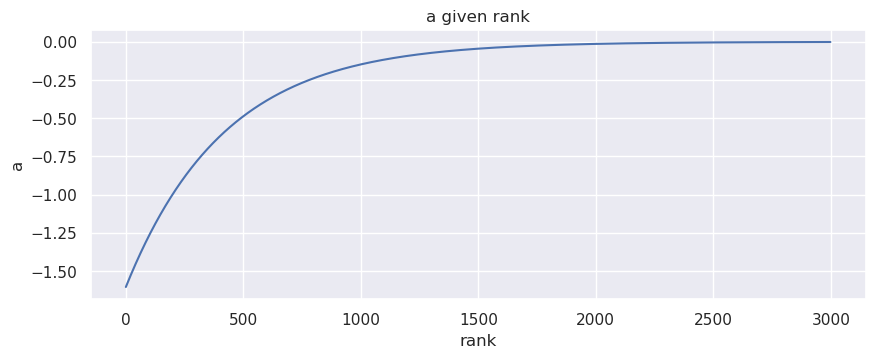

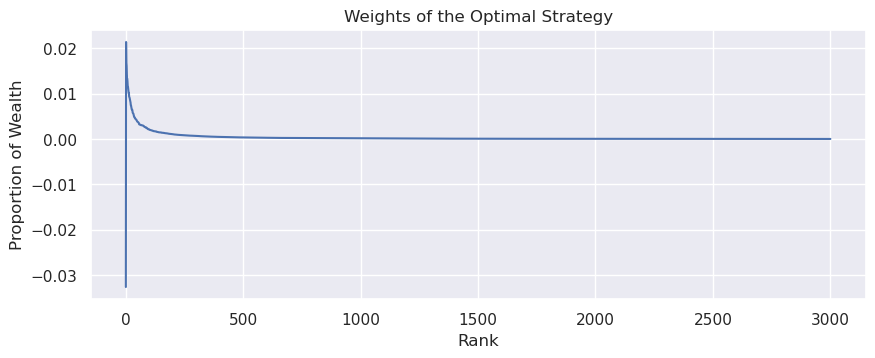

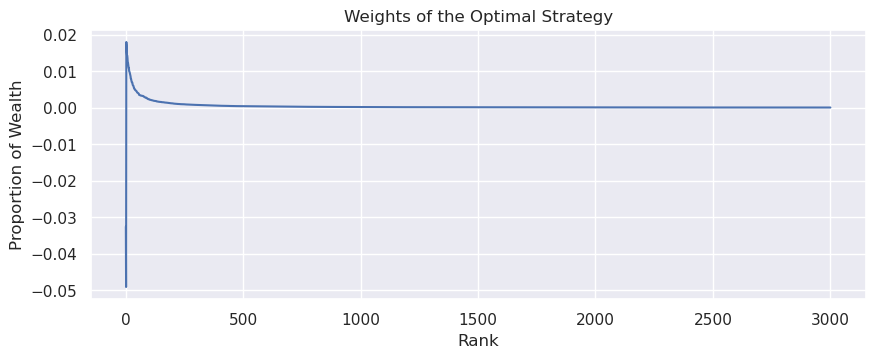

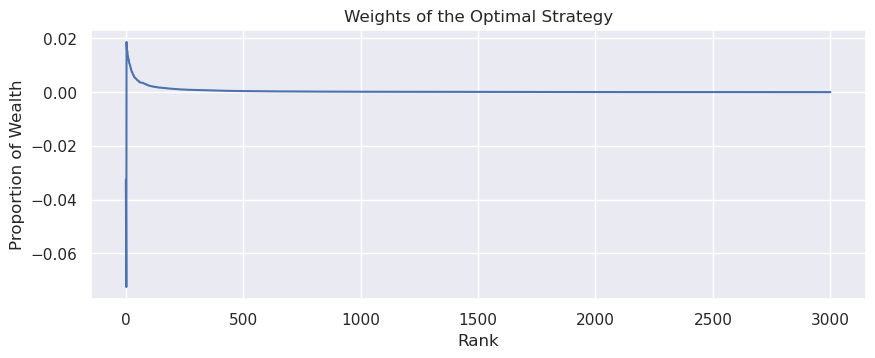

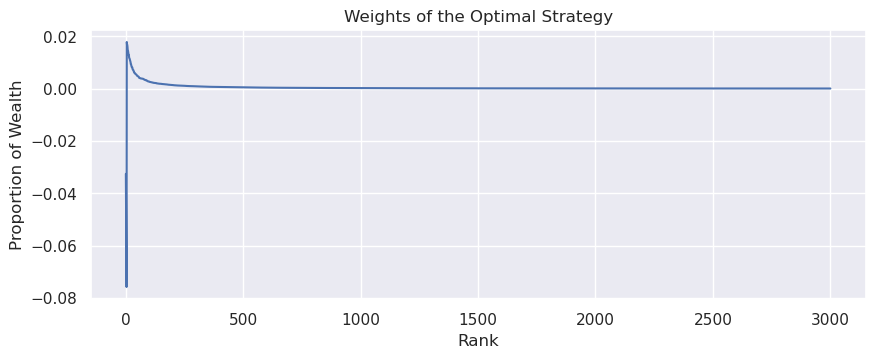

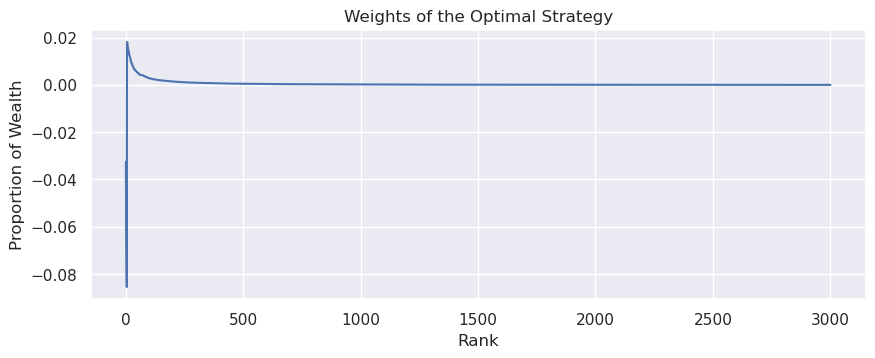

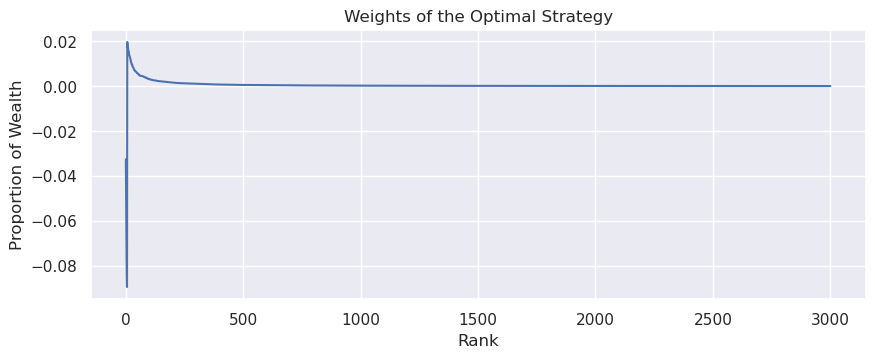

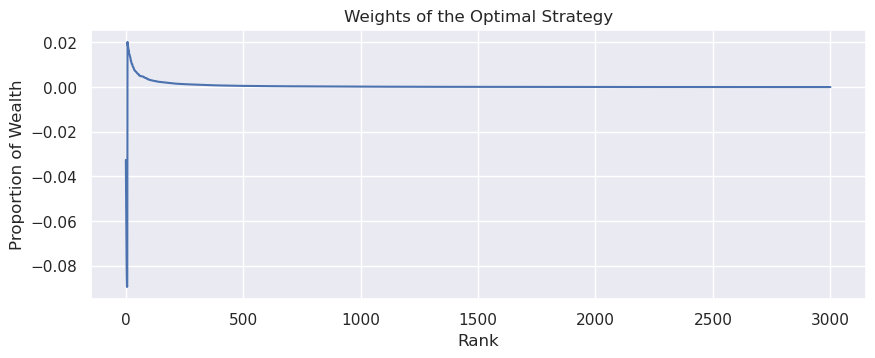

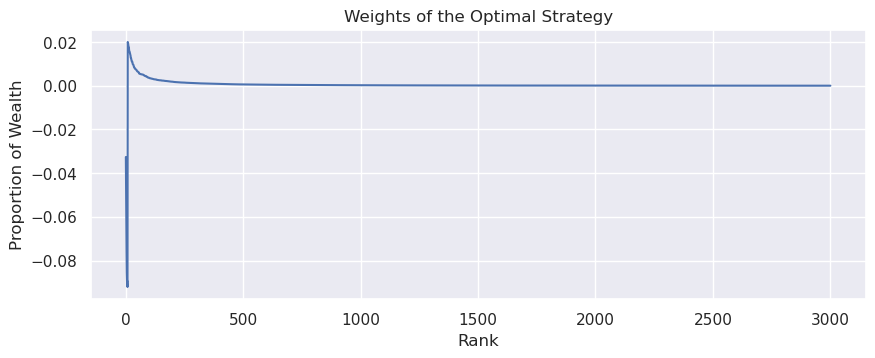

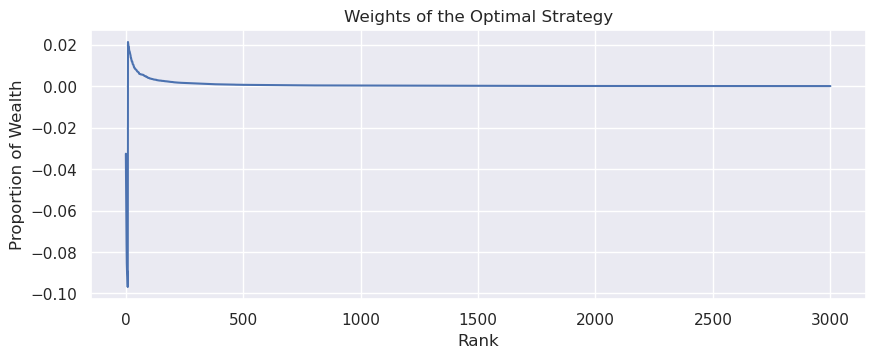

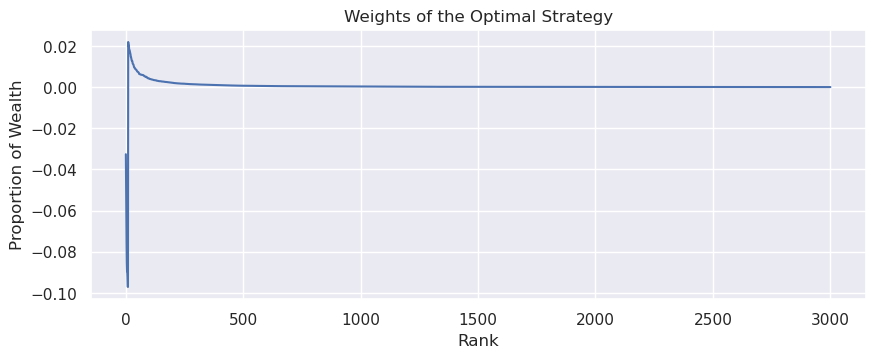

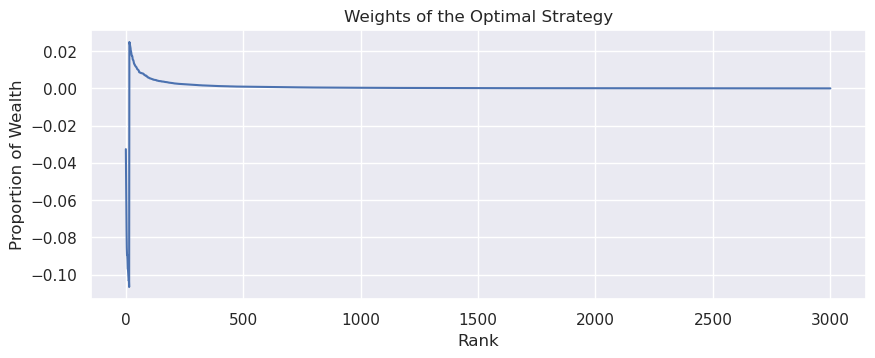

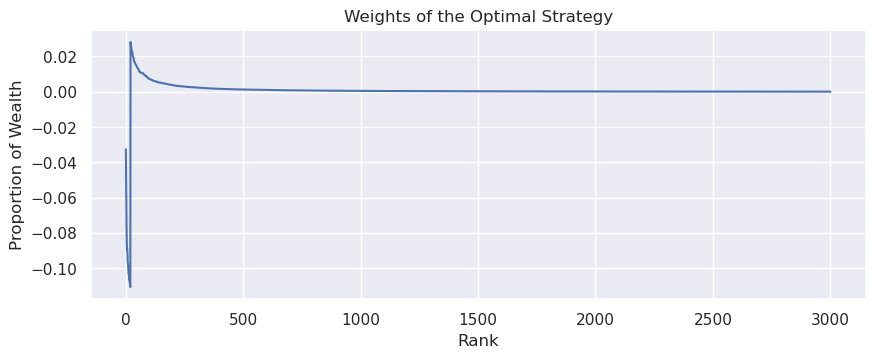

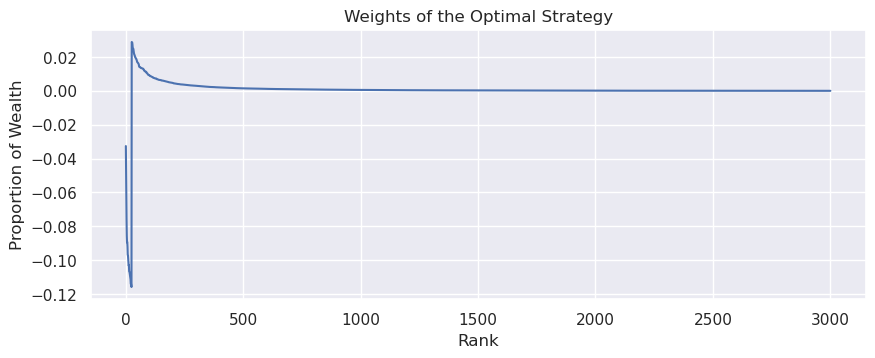

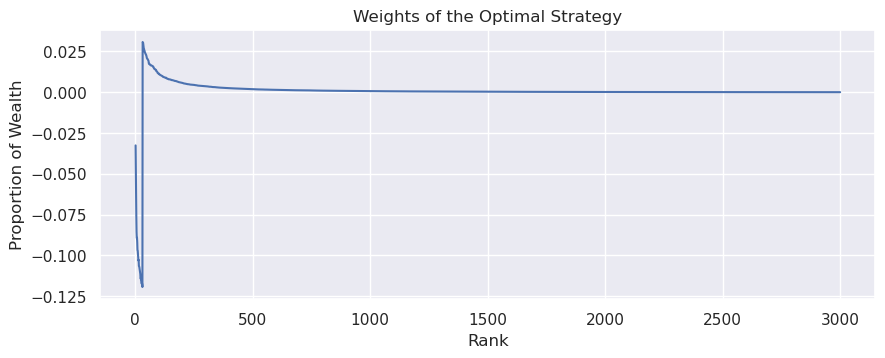

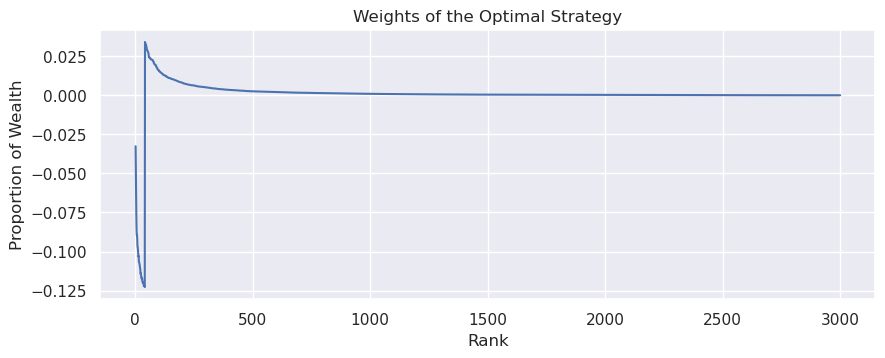

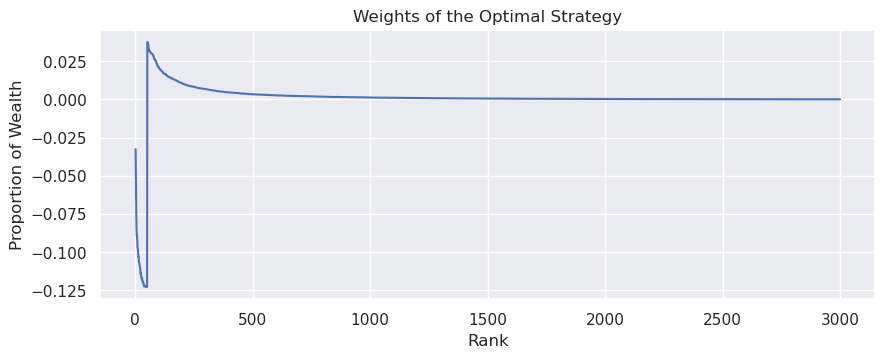

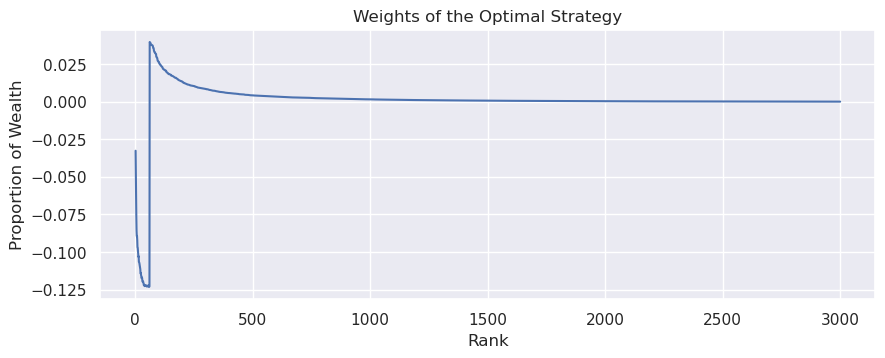

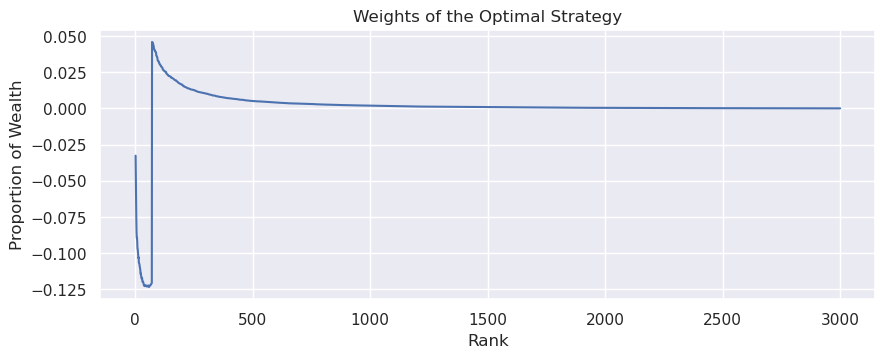

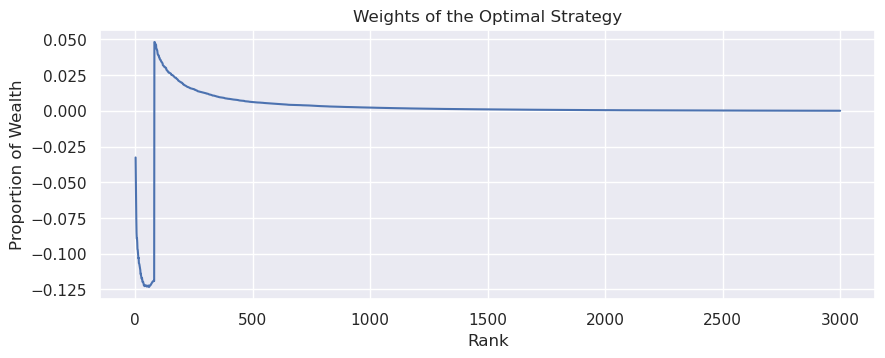

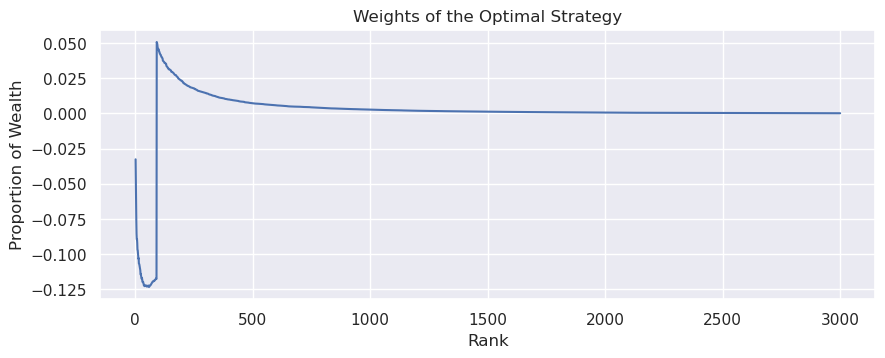

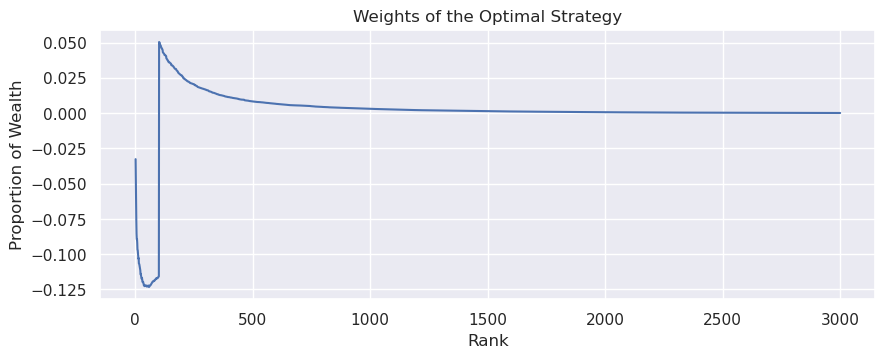

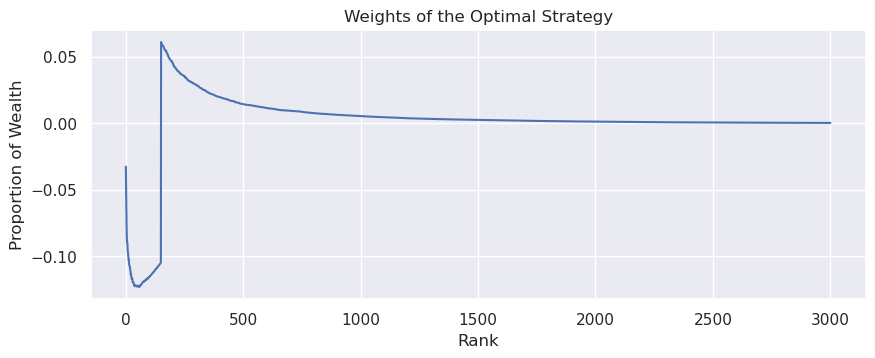

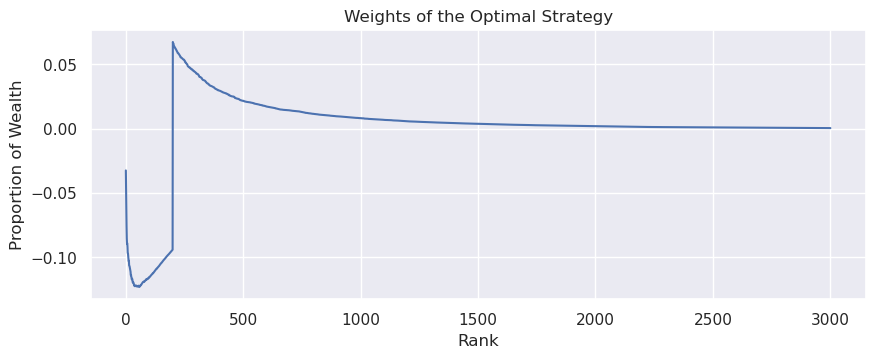

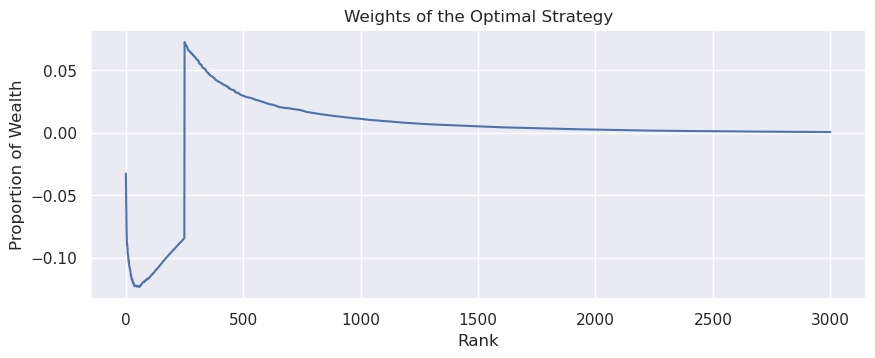

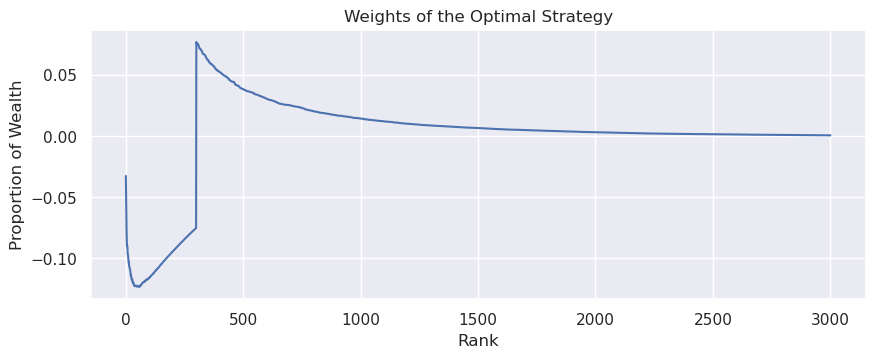

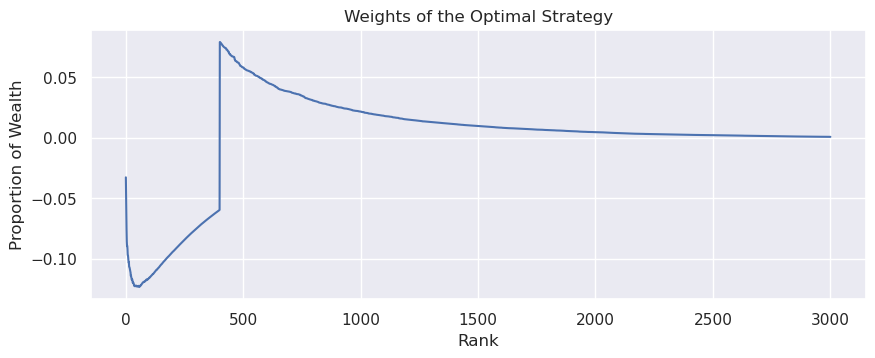

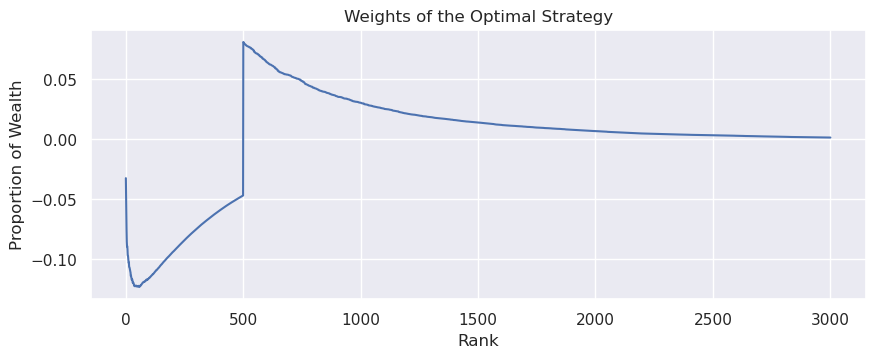

In [5]:
method = 'direct_log'
smooth_method = 'exponential_decay'
smooth_a = False
initial_folder_path = '../3-results/4-different_leverage_scalers/daily/1-start_year_'+str(backtest_start_year)+'/'
plot_date = '2014-03-28'
setting = 'mixed'
smooth_parameter = 2
risk_free_rate = 0

leverage_scalers = [0.2]#, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]#[0.1, 0.01, 0.001, 0.0001]
Ns = list(range(1, 10)) + list(range(10, 30, 5)) + list(range(30, 100, 10)) + list(range(100,300, 50)) + list(range(300,2000, 100))
meta_plots_up_to = [20, 100, 200, 500, 1000, 2000]

for leverage_scaler in leverage_scalers:
    folder_path = initial_folder_path + 'leverage_scaler=' + str(leverage_scaler) + '/'
    os.makedirs(folder_path, exist_ok=True)

    # Meta Results
    average_returns_percentage = []
    average_returns = []
    sd_returns = []
    end_period_cumulative_wealths = []
    sharpe_ratios = []
    max_drawdowns = []
    calmar_ratios = []

    # Meta Plots 
    average_returns_folder = folder_path + '1-average_returns/'
    end_period_cumulative_wealths_folder = folder_path + '2-end_period_cumulative_wealths/'
    metrics_folder = folder_path + '3-metrics/'
    sharpe_ratios_folder = metrics_folder + '1-sharpe_ratios/'
    max_drawdowns_folder = metrics_folder + '2-max_drawdowns/'
    calmar_ratios_folder = metrics_folder + '4-calmar_ratios/'
    os.makedirs(average_returns_folder, exist_ok=True)
    os.makedirs(end_period_cumulative_wealths_folder, exist_ok=True)
    os.makedirs(sharpe_ratios_folder, exist_ok=True)
    os.makedirs(max_drawdowns_folder, exist_ok=True)
    os.makedirs(calmar_ratios_folder, exist_ok=True)
    
    # Folder Paths
    strategies_folder = folder_path + '4-strategies/'
    returns_folder = folder_path + '5-returns/'
    cumulative_returns_folder = folder_path + '6-cumulative_returns/'
    os.makedirs(strategies_folder, exist_ok=True)
    os.makedirs(returns_folder, exist_ok=True)
    os.makedirs(cumulative_returns_folder, exist_ok=True)


    a = estimate_a(df_a_estimation.weights_by_rank, smooth_method=smooth_method, smooth_parameter=smooth_parameter,  smooth_a=smooth_a)
    plot_a(a[:-1], data_path=folder_path + 'a_plot')

    for N in Ns:
        strategy = compute_weights_optimal_open(setting=setting, N=N, a=a, weights_by_rank=df_backtest.weights_by_rank,
                                                leverage_scaler=leverage_scaler)
        # strategy = compute_weights_market_portfolio(weights_by_rank=df_backtest.weights_by_rank)
        backtest = Backtest(strategy=strategy, weights_permno_by_rank=df_backtest.weights_permno_by_rank, 
                            returns_by_permno=df_backtest.returns_by_permno, risk_free_rate=risk_free_rate)
        backtest.run()
        
        # Meta Results
        average_returns_percentage.append(backtest.average_return_percentage)
        average_returns.append(backtest.average_return)
        sd_returns.append(backtest.sd_return)
        end_period_cumulative_wealths.append(backtest.end_period_cumulative_wealth)
        sharpe_ratios.append(backtest.sharpe_ratio)
        max_drawdowns.append(backtest.max_drawdown)
        calmar_ratios.append(backtest.calmar_ratio)

        # Plotting for each N
        plot_strategy(strategy=strategy, date=plot_date, data_path=strategies_folder+'strategy_plot_N='+str(N))
        backtest.plot_rets(data_path=returns_folder+'returns_N='+str(N))
        backtest.plot_cumulative_rets(data_path=cumulative_returns_folder+'cumulative_returns_N='+str(N))

    # Meta Plots
    create_gif(strategies_folder, 'strategies_evolution')
    create_gif(returns_folder, 'returns')
    create_gif(cumulative_returns_folder, 'cumulative_returns')

    for N_up_to in meta_plots_up_to:
        plot_given_N(Ns=Ns, vector=average_returns_percentage, N_up_to=N_up_to, folder=average_returns_folder, 
                     name='average_returns_up_to_'+str(N_up_to), title='Average Returns Monthly (%)')
        plot_given_N(Ns=Ns, vector=end_period_cumulative_wealths, N_up_to=N_up_to, folder=end_period_cumulative_wealths_folder, 
                     name='end_of_period_wealth_up_to_'+str(N_up_to), title='End of Period Wealths')
        plot_given_N(Ns=Ns, vector=sharpe_ratios, N_up_to=N_up_to, folder=sharpe_ratios_folder, 
                     name='sharpe_ratios_up_to_'+str(N_up_to), title='Sharpe Ratios')
        plot_given_N(Ns=Ns, vector=max_drawdowns, N_up_to=N_up_to, folder=max_drawdowns_folder, 
                     name='max_drawdowns_up_to_'+str(N_up_to), title='Maximum Drawdown')
        plot_given_N(Ns=Ns, vector=calmar_ratios, N_up_to=N_up_to, folder=calmar_ratios_folder, 
                     name='calmar_ratios_up_to_'+str(N_up_to), title='Calmar Ratios')


#### Trying Different Smooth Methods

In [ ]:
method = 'direct_log'
smooth_methods = ['exponential_decay', 'polynomial']
smooth_a = False
initial_folder_path = '../3-results/3-sharpe_ratios/'
plot_date = '2013-03-28'

settings = ['pure', 'mixed']
smooth_parameter = 2
Ns = list(range(1, 10)) + list(range(10, 30, 5)) + list(range(30, 100, 10)) + list(range(100,300, 50)) + list(range(300,2000, 100))
meta_plots_up_to = [20, 100, 200, 500, 1000, 2000]
strategy_plots_N = [10, 100, 1000]
risk_free_rate = 0

for setting in settings:
    folder_path = initial_folder_path + setting + '/'

    for smooth_method in smooth_methods:
        average_returns = []
        sd_returns = []
        final_cumulative_returns = []
        
        new_folder = folder_path + smooth_method + '/'
        os.makedirs(new_folder, exist_ok=True)

        a = estimate_a(df_a_estimation.weights_by_rank, smooth_method=smooth_method, smooth_parameter=smooth_parameter,  smooth_a=smooth_a)
        plot_a(a[:-1], data_path=new_folder + 'a_plot')

        for N in Ns:
            strategy = compute_weights_optimal_open(setting=setting, N=N, a=a, weights_by_rank=df_backtest.weights_by_rank)
            if N in strategy_plots_N:
                plot_strategy(strategy=strategy, date=plot_date, data_path=new_folder+'strategy_plot_N='+str(N))
            backtest = Backtest(strategy=strategy, weights_permno_by_rank=df_backtest.weights_permno_by_rank, returns_by_permno=df_backtest.returns_by_permno)
            backtest.run()

            average_return = round(np.mean(backtest.rets), 4)
            sd_return = round(np.std(backtest.rets), 4)
            backtest.plot_rets()
            final_cumulative_return = round(backtest.cumulative_rets[-1], 4)

            average_returns.append(average_return)
            sd_returns.append(sd_return)
            final_cumulative_returns.append(final_cumulative_return)
            # print('N =', N, '. Average return:', average_return, '; Final Cumulative Return:', final_cumulative_return)

        # Plots
        returns_folder = new_folder + 'average_returns/'
        os.makedirs(returns_folder, exist_ok=True)
        sharpe_ratios_folder = new_folder + 'sharpe_ratios/'
        os.makedirs(sharpe_ratios_folder, exist_ok=True)
        for first_print in meta_plots_up_to:
            plot_given_N(Ns, average_returns, first_print, returns_folder, 'average_returns_up_to_'+str(first_print))
            plot_sharpe_ratio(Ns, average_returns, sd_returns, risk_free_rate, first_print, sharpe_ratios_folder, 'sharpe_ratios_up_to_'+str(first_print))
